In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

In [2]:
data = pd.read_csv('data_small.csv')
df = data
df['day'] = pd.to_datetime(df.day)
df1 = data.groupby(by=['dns_qdomainname','day']).sum()

# df2 counts unique query names by domain name and day
df2 = data.groupby(by=['dns_qdomainname','day'])[['shieldid','dns_qname']].nunique()
df2 = pd.DataFrame(df2)
df2.rename(columns={'shieldid': 'num_shieldid', 'dns_qname': 'num_dns_qname'}, inplace=True)
    
# Concatenate df1 and df2 into df
df = pd.concat([df1, df2], axis=1)
df.reset_index(level=1, inplace=True)

In [3]:
def bin_and_merge(df, group_col, bin_col, bin_label):
    # Group by domain and sum the values for the given column
    group_by_domain = df.groupby(df.index)[bin_col].sum().reset_index()

    # Sort the data by ascending order
    group_by_domain.sort_values(by=bin_col, inplace=True)

    # Create the bin edges for 5 equal cuts
    bin_edges_a = pd.qcut(group_by_domain[bin_col], q=group_by_domain[bin_col].nunique(), duplicates='drop').sort_values().unique()

    # Create the bin labels
    bin_labels = [f"{int(bin_edges_a[i].left+1)}-{int(bin_edges_a[i].right)}" for i in range(len(bin_edges_a))]

    # Convert bin edges to floats
    bin_edges = [float(bin_edge.left) for bin_edge in bin_edges_a]
    bin_edges.append(float(bin_edges_a[-1].right))

    # Bin the data and assign the labels to each row
    group_by_domain['group'] = pd.cut(group_by_domain[bin_col], bins=bin_edges, labels=bin_labels)

    # Merge the labeled data back to the original dataframe
    df = pd.merge(df, group_by_domain[['dns_qdomainname', 'group']], on='dns_qdomainname', how='left')
    df.rename(columns={'group': bin_label}, inplace=True)
    df.set_index('dns_qdomainname', inplace=True)

    return df

# Apply the binning to different columns
df = bin_and_merge(df, 'dns_qdomainname', 'num_clients', 'client_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_responses', 'responses_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_shieldid', 'shield_sum_group')

In [4]:
import time
start_time = time.time()

# list the sum groups
sum_groups = [
    ("client_sum_group", "num_clients", "prob_obs_num_clients"),
    ("responses_sum_group", "num_responses", "prob_obs_num_responses"),
    ("shield_sum_group", "num_shieldid", "prob_obs_num_shield")
]

for group_col, num_col, prob_col in sum_groups:
    # loop over each sum group
    for group_val in df[group_col].sort_values().unique():
        # empty dictionary
        dict_ = {}
        # slice the df to sum group
        case = df.loc[df[group_col]==group_val]
        # create the number of bins so we get discrete bins
        num_bins = case[num_col].max()
        # cumulative distribution of the empirical observations
        pds, bins = np.histogram(case[num_col], bins=num_bins, density=False)
        probs = list(1 - (pds/np.sum(pds)).cumsum())
        probs.insert(0,1)
        probs.pop(-1)
        probs = np.array(probs)
        # list the integer bin values
        bins = list(bins)
        for i in range(len(bins)):
            bins[i] = int(i)
        bins.pop(0)
        bins = np.array(bins)
        if len(bins) == len(probs):
            # create dictionary
            dict_ = dict(zip(bins, probs))
            # replace the values in the column with dictionary values using apply
            df.loc[df[group_col] == group_val, prob_col] = case[num_col].apply(lambda x: dict_.get(int(x), 0))
            
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1884.3589868545532 seconds


In [43]:
df['total_prob'] = df.prob_obs_num_shield * df.prob_obs_num_clients*(1) * df.prob_obs_num_responses

In [ ]:
df['month'] = df['day'].dt.month

# Create normalized probabilities

In [163]:
new_0 = (df.groupby(by='day')['num_responses'].sum() / df.num_responses.sum()) * df.day.nunique()
new1 = df.groupby(by = ['day', 'dns_qdomainname'])['prob_obs_num_responses'].sum().unstack()
new_responses = new1.mul(new_0,axis=0).stack().reset_index()
new_responses['normalized_prob_responses'] = new_responses[0]
norm = pd.merge(df, new_responses, on=['day','dns_qdomainname'], how='left')

In [167]:
new_2 = (df.groupby(by='day')['num_clients'].sum() / df.num_clients.sum()) * df.day.nunique()
new_3 = df.groupby(by = ['day', 'dns_qdomainname'])['prob_obs_num_clients'].sum().unstack()
new_responses1 = new_3.mul(new_2,axis=0).stack().reset_index()
new_responses1['normalized_prob_clients'] = new_responses1[0]
norm1 = pd.merge(norm, new_responses1, on=['day','dns_qdomainname'], how='left')

In [170]:
new_4 = (df.groupby(by='day')['num_shieldid'].sum() / df.num_shieldid.sum()) * df.day.nunique()
new_5 = df.groupby(by = ['day', 'dns_qdomainname'])['prob_obs_num_shield'].sum().unstack()
new_responses2 = new_5.mul(new_4,axis=0).stack().reset_index()
new_responses2['normalized_prob_shields'] = new_responses2[0]
norm2 = pd.merge(norm1, new_responses2, on=['day','dns_qdomainname'], how='left')
norm = norm2

In [191]:
norm['normalized_total_prob'] = norm.normalized_prob_responses * norm.normalized_prob_clients * norm.normalized_prob_shields

In [207]:
norm[norm.day == '2022-12-23'].sort_values(by = 'normalized_total_prob').head(100)

,day,dns_qdomainname,num_clients,num_responses,num_shieldid,num_dns_qname,client_sum_group,responses_sum_group,shield_sum_group,prob_obs_num_clients,...,prob_obs_num_shield,total_prob,month,0_x,normalized_prob_responses,0_y,normalized_prob_clients,0,normalized_prob_shields,normalized_total_prob
281110,2022-12-23,axds.co,106,110,1,71,150-151,159-159,6-6,0.000184,...,1.000000,3.643026e-07,12,0.000930,0.000930,0.000049,0.000049,0.543853,0.543853,2.458373e-08
2184427,2022-12-23,seattlemet.com,13,172,5,1,143-144,4684-4746,51-51,0.013264,...,0.004121,4.785414e-06,12,0.041130,0.041130,0.003503,0.003503,0.002241,0.002241,3.229275e-07
451221,2022-12-23,canadiangeographic.ca,11,148,4,1,76-76,2305-2328,32-32,0.017953,...,0.007020,6.264584e-06,12,0.023355,0.023355,0.004741,0.004741,0.003818,0.003818,4.227442e-07
2697811,2022-12-23,voot.com,15,405,1,5,71-71,765-768,16-16,0.004898,...,1.000000,6.583876e-06,12,0.000632,0.000632,0.001294,0.001294,0.543853,0.543853,4.442906e-07
2045082,2022-12-23,rcplatformhk.com,15,471,1,15,61-61,2161-2178,14-14,0.001427,...,1.000000,8.111807e-06,12,0.002671,0.002671,0.000377,0.000377,0.543853,0.543853,5.473978e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29414,2022-12-23,8card.net,11,174,1,6,236-237,2305-2328,38-38,0.050905,...,1.000000,1.959782e-03,12,0.018089,0.018089,0.013443,0.013443,0.543853,0.543853,1.322492e-04
652105,2022-12-23,cyborgsecurity.io,2,88,1,2,1-2,88-88,1-2,0.405185,...,1.000000,2.002093e-03,12,0.002322,0.002322,0.107004,0.107004,0.543853,0.543853,1.351044e-04
643913,2022-12-23,curbed.com,5,29,2,3,116-116,715-718,70-70,0.032000,...,0.395287,2.019931e-03,12,0.075030,0.075030,0.008451,0.008451,0.214978,0.214978,1.363082e-04
351789,2022-12-23,bioreference.com,5,60,1,4,30-30,299-299,8-8,0.070169,...,1.000000,2.093121e-03,12,0.014015,0.014015,0.018531,0.018531,0.543853,0.543853,1.412472e-04


<AxesSubplot:xlabel='day'>

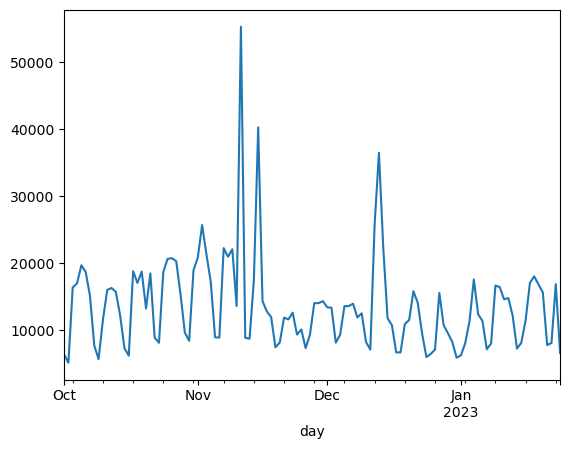

In [107]:
df.groupby(by='day')["prob_obs_num_responses"].sum().plot()

<AxesSubplot:>

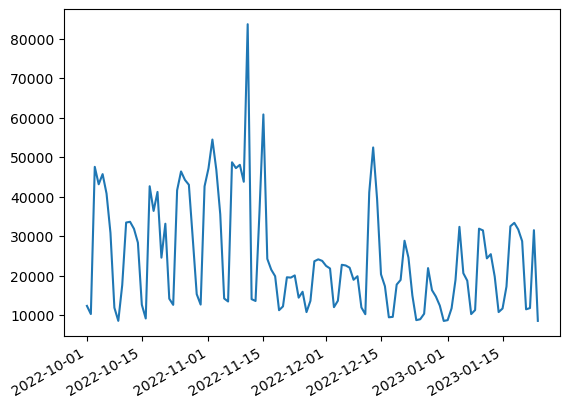

In [91]:
abc = df.sort_values(by='total_prob')
abc.day.value_counts().plot()

In [208]:
domain = 'intrustion.com'  #oui-000199d.com
test = norm.loc[df.index==domain]
test.sort_values(by='normalized_total_prob')

,day,dns_qdomainname,num_clients,num_responses,num_shieldid,num_dns_qname,client_sum_group,responses_sum_group,shield_sum_group,prob_obs_num_clients,...,prob_obs_num_shield,total_prob,month,0_x,normalized_prob_responses,0_y,normalized_prob_clients,0,normalized_prob_shields,normalized_total_prob
1283247,2022-11-27,intrustion.com,8,36,1,4,288-291,1310-1315,59-60,0.170521,...,1.0,0.042449,11,0.061205,0.061205,0.024174,0.024174,0.425966,0.425966,0.000630
1283240,2022-11-20,intrustion.com,6,27,1,3,288-291,1310-1315,59-60,0.292321,...,1.0,0.099101,11,0.088730,0.088730,0.038162,0.038162,0.402604,0.402604,0.001363
1283239,2022-11-19,intrustion.com,6,27,1,3,288-291,1310-1315,59-60,0.292321,...,1.0,0.099101,11,0.087299,0.087299,0.041227,0.041227,0.406164,0.406164,0.001462
1283245,2022-11-25,intrustion.com,8,36,1,4,288-291,1310-1315,59-60,0.170521,...,1.0,0.042449,11,0.072677,0.072677,0.040109,0.040109,0.563547,0.563547,0.001643
1283233,2022-11-13,intrustion.com,8,36,1,4,288-291,1310-1315,59-60,0.170521,...,1.0,0.042449,11,0.136329,0.136329,0.037522,0.037522,0.525315,0.525315,0.002687
1283246,2022-11-26,intrustion.com,4,18,1,2,288-291,1310-1315,59-60,0.500794,...,1.0,0.250550,11,0.134276,0.134276,0.063409,0.063409,0.364819,0.364819,0.003106
1283199,2022-10-09,intrustion.com,6,27,1,3,288-291,1310-1315,59-60,0.292321,...,1.0,0.099101,10,0.163188,0.163188,0.067786,0.067786,0.414177,0.414177,0.004582
1283206,2022-10-16,intrustion.com,4,18,1,2,288-291,1310-1315,59-60,0.500794,...,1.0,0.250550,10,0.180681,0.180681,0.100896,0.100896,0.386254,0.386254,0.007041
1283226,2022-11-06,intrustion.com,4,18,1,2,288-291,1310-1315,59-60,0.500794,...,1.0,0.250550,11,0.155686,0.155686,0.099237,0.099237,0.514666,0.514666,0.007952
1283248,2022-11-28,intrustion.com,8,36,1,4,288-291,1310-1315,59-60,0.170521,...,1.0,0.042449,11,0.101046,0.101046,0.080860,0.080860,1.022044,1.022044,0.008351


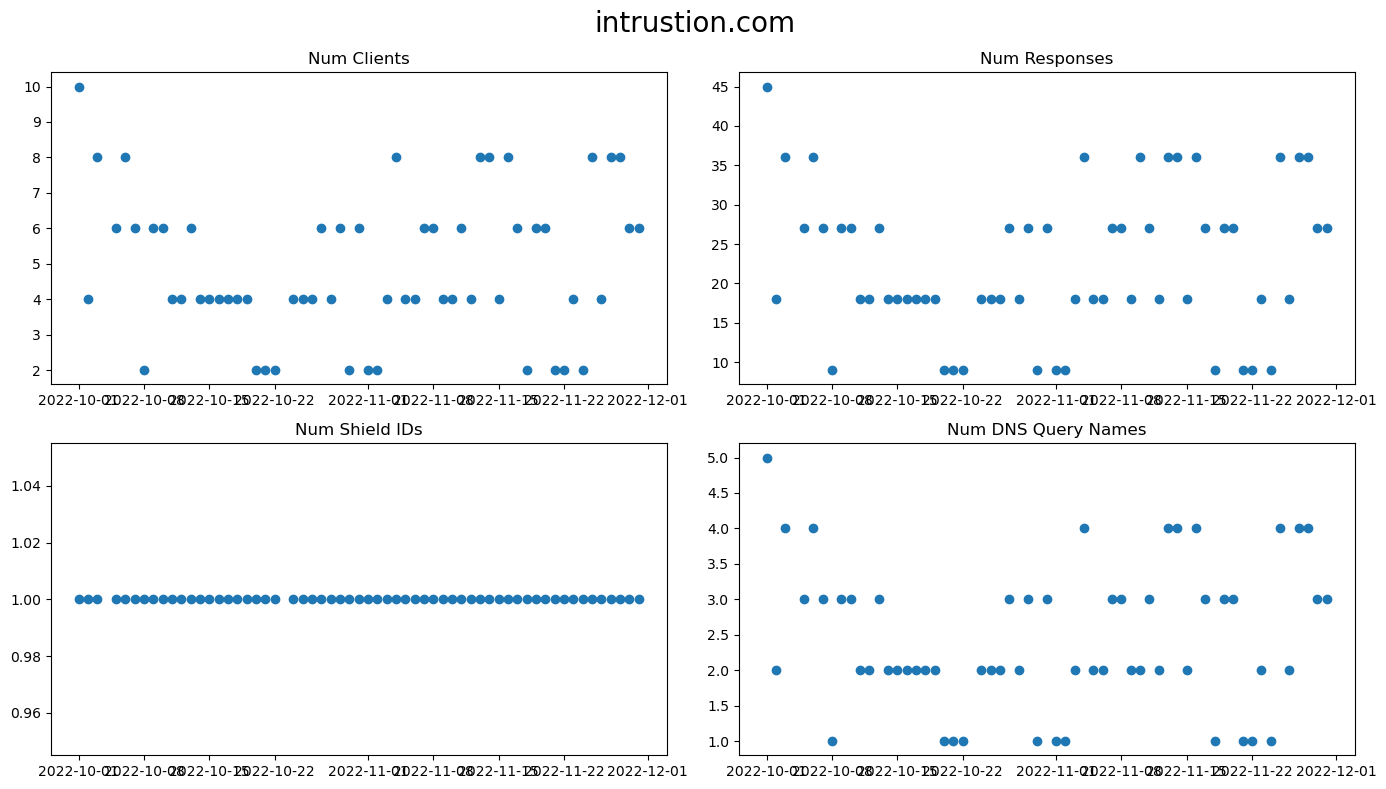

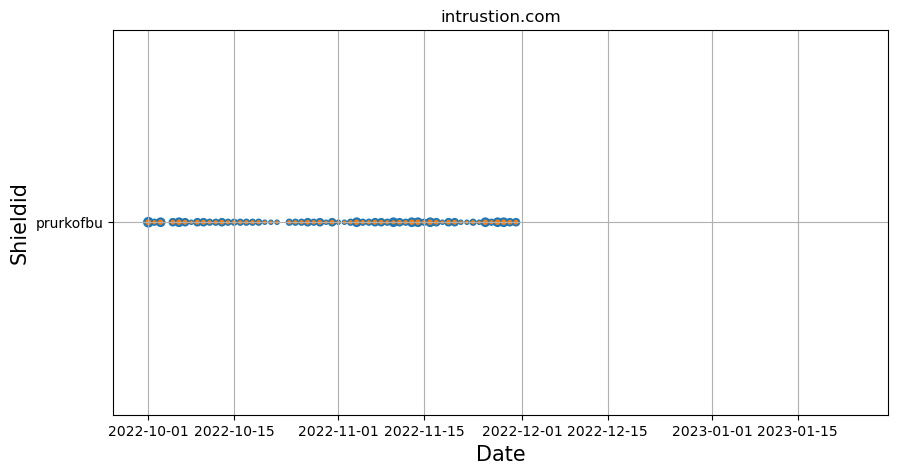

In [209]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[(0,0)].scatter(test.day, test.num_clients)
axs[(0,0)].set_title('Num Clients')

axs[(0,1)].scatter(test.day, test.num_responses)
axs[(0,1)].set_title('Num Responses')

axs[(1,0)].scatter(test.day, test.num_shieldid)
axs[(1,0)].set_title('Num Shield IDs')

axs[(1,1)].scatter(test.day, test.num_dns_qname)
axs[(1,1)].set_title('Num DNS Query Names')

plt.suptitle(str(domain), fontsize=20)
plt.tight_layout()
plt.show()

def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new

domain_case_new = get_domain_case_new(data, domain)

# Plot
plt.figure(figsize=(10,5))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)
plt.title(domain)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')